In [1]:
import json
import timeit
import numpy as np
import pandas as pd
import tensorflow as tf
from algo.utils.data import *
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from algo.models import RecurrentNeuralNet, CNN

%matplotlib inline

In [2]:
data_df = pd.read_csv("data/MAIS00110.csv", parse_dates=['DateTime'], index_col=0)
#NOTE: Data available for 2011-12-28 11:00:00 to 2014-03-31 22:00:00
data_df.head()

,Consumption,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,LCLid
DateTime,,,,,,,,,,,,,
2011-12-28 11:00:00,0.223,13.52,239.0,11.19,6.55,1019.82,11.19,6.96,rain,partly-cloudy-day,0.73,Mostly Cloudy,MAIS00110
2011-12-28 12:00:00,0.381,13.52,252.0,10.82,6.06,1019.41,10.82,6.88,rain,partly-cloudy-day,0.72,Mostly Cloudy,MAIS00110
2011-12-28 13:00:00,0.939,13.52,254.0,10.26,5.64,1019.04,10.26,7.12,rain,partly-cloudy-day,0.73,Partly Cloudy,MAIS00110
2011-12-28 14:00:00,1.967,13.07,261.0,9.59,3.72,1019.13,6.41,7.01,rain,partly-cloudy-day,0.67,Partly Cloudy,MAIS00110
2011-12-28 15:00:00,3.182,13.47,262.0,8.96,2.48,1019.46,5.59,7.04,rain,partly-cloudy-day,0.64,Partly Cloudy,MAIS00110


In [3]:
#NOTE: We observe that some Consumption values are set to 0.0
data_df.tail()

,Consumption,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,LCLid
DateTime,,,,,,,,,,,,,
2014-03-31 18:00:00,0.0,14.81,122.0,15.41,7.28,1011.59,15.41,1.98,rain,clear-day,0.58,Clear,MAIS00110
2014-03-31 19:00:00,0.0,14.15,130.0,14.62,7.68,1011.83,14.62,1.58,rain,partly-cloudy-night,0.63,Partly Cloudy,MAIS00110
2014-03-31 20:00:00,0.0,14.07,141.0,13.62,7.91,1011.98,13.62,1.14,rain,partly-cloudy-night,0.68,Partly Cloudy,MAIS00110
2014-03-31 21:00:00,0.0,12.96,135.0,13.03,7.96,1011.97,13.03,1.11,rain,clear-night,0.71,Clear,MAIS00110
2014-03-31 22:00:00,0.0,13.13,110.0,12.51,7.97,1011.83,12.51,0.94,rain,clear-night,0.74,Clear,MAIS00110


In [4]:
# List data types of data_df
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19773 entries, 2011-12-28 11:00:00 to 2014-03-31 22:00:00
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Consumption          19773 non-null  float64
 1   visibility           19773 non-null  float64
 2   windBearing          19773 non-null  float64
 3   temperature          19773 non-null  float64
 4   dewPoint             19773 non-null  float64
 5   pressure             19773 non-null  float64
 6   apparentTemperature  19773 non-null  float64
 7   windSpeed            19773 non-null  float64
 8   precipType           19773 non-null  object 
 9   icon                 19773 non-null  object 
 10  humidity             19773 non-null  float64
 11  summary              19773 non-null  object 
 12  LCLid                19773 non-null  object 
dtypes: float64(9), object(4)
memory usage: 2.1+ MB


In [5]:
#NOTE: Compute some statistics
data_df.describe()

,Consumption,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
count,19773.00000,19773.000000,19773.000000,19773.000000,19773.000000,19773.000000,19773.000000,19773.000000,19773.000000
mean,8.35643,11.230482,195.358367,10.584152,6.535089,1014.112955,9.360479,3.883330,0.776780
std,6.32387,3.018775,91.679945,5.894142,5.119776,11.427490,7.050034,2.034414,0.141779
min,0.00000,0.180000,0.000000,-5.640000,-9.980000,975.740000,-8.880000,0.040000,0.230000
25%,1.66300,10.220000,118.000000,6.480000,2.800000,1007.470000,3.920000,2.380000,0.690000
50%,8.28700,12.260000,217.000000,10.040000,6.540000,1014.620000,10.040000,3.660000,0.810000
75%,12.17100,13.080000,257.000000,14.660000,10.430000,1022.060000,14.660000,5.060000,0.890000
max,32.61500,16.090000,359.000000,32.400000,19.880000,1043.320000,32.420000,14.800000,1.000000


In [6]:
#NOTE: Data available for 2011-12-28 11:00:00 to 2014-03-31 22:00:00
min(data_df.index), max(data_df.index)

(Timestamp('2011-12-28 11:00:00'), Timestamp('2014-03-31 22:00:00'))

In [7]:
# Replace zero-valued consumption for NAN
data_df.Consumption.replace(to_replace=0, value=np.nan, inplace=True)

# Compute a time interpolation on consumption NAN values
data_df.Consumption.interpolate(method='time', inplace=True)

<AxesSubplot:xlabel='DateTime'>

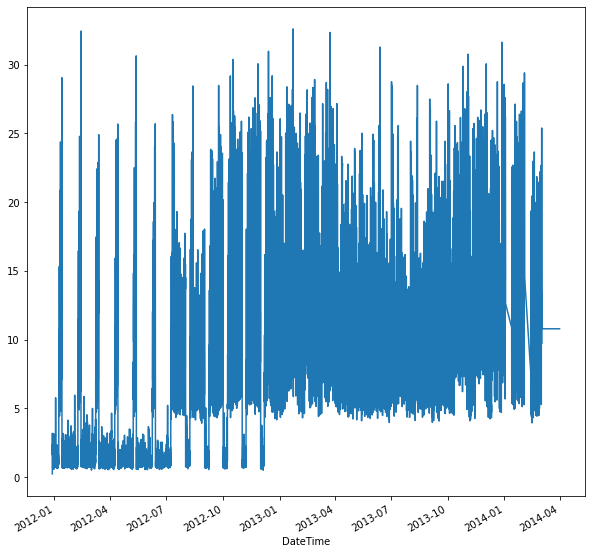

In [9]:
# Plot the data
data_df['Consumption'].plot(kind='line', figsize=(10, 10))

## Specify configuration file

In [10]:
config_file = "data/parameter.json"

try:
    with open(config_file) as f:
        params = json.load(f)
except IOError:
    print("Config file not found.")

# Display parameters content
params

{'EXPERIMENT_NAME': 'cnn',
 'DEFAULT_PARAMS': {'epochs': 100, 'forecast_horizon': 24},
 'RNN_PARAMS': {'num_stack_layers': [1, 2, 3],
  'units': [32, 64, 128],
  'dropout': [0],
  '--encoder-dim-1': 5,
  '--encoder-dim-2': 0,
  '--decoder-dim-1': 5,
  '--decoder-dim-2': 0,
  '--batch-size': 32,
  '--T': 72,
  '--learning-rate': 0.01,
  '--alpha': 0},
 'SCRIPT_PARAMS': {'--latent-dim-1': 5,
  '--latent-dim-2': 5,
  '--kernel-size': 3,
  '--batch-size': 32,
  '--T': 72,
  '--learning-rate': 0.01,
  '--alpha': 0},
 'HYPER_PARAMS': {'--latent-dim-1': [5, 10, 15],
  '--latent-dim-2': [0, 5, 10],
  '--kernel-size': 3,
  '--batch-size': [16, 32],
  '--T': [72, 168, 336],
  '--learning-rate': [0.01, 0.001, 0.0001],
  '--alpha': [0.1, 0.001, 0]},
 'CATEGORIAL_COLS': ['precipType', 'icon', 'summary'],
 'MODEL_NAME': 'cnn-best'}

In [11]:
# Select categorical features
categorical_data = data_df.select_dtypes(include=['object']).copy()
categorical_data.columns

Index(['precipType', 'icon', 'summary', 'LCLid'], dtype='object')

In [12]:
# Make a pipeline with the steps DateTimeFeatures and CyclicalDateTimeFeatures
transforms = Pipeline(
    steps=[
        # Must create the date/time features before encoding
        ("date_time_features", DateTimeFeatures()),
        ("cylical_date_time_features", CyclicalDateTimeFeatures()),
        #("holidays_features", HolidaysFeatures()),
    ]
)

In [13]:
# Apply the data transformations
transformed_data = transforms.transform(data_df)
transformed_data.head()

,Consumption,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary,LCLid,time_of_day,day_of_year,sin_time_of_day,cos_time_of_day,sin_day_of_year,cos_day_of_year
DateTime,,,,,,,,,,,,,,,,,,,
2011-12-28 11:00:00,0.223,13.52,239.0,11.19,6.55,1019.82,11.19,6.96,rain,partly-cloudy-day,0.73,Mostly Cloudy,MAIS00110,11.0,362,2.588190e-01,-0.965926,-0.068615,0.997643
2011-12-28 12:00:00,0.381,13.52,252.0,10.82,6.06,1019.41,10.82,6.88,rain,partly-cloudy-day,0.72,Mostly Cloudy,MAIS00110,12.0,362,1.224647e-16,-1.000000,-0.068615,0.997643
2011-12-28 13:00:00,0.939,13.52,254.0,10.26,5.64,1019.04,10.26,7.12,rain,partly-cloudy-day,0.73,Partly Cloudy,MAIS00110,13.0,362,-2.588190e-01,-0.965926,-0.068615,0.997643
2011-12-28 14:00:00,1.967,13.07,261.0,9.59,3.72,1019.13,6.41,7.01,rain,partly-cloudy-day,0.67,Partly Cloudy,MAIS00110,14.0,362,-5.000000e-01,-0.866025,-0.068615,0.997643
2011-12-28 15:00:00,3.182,13.47,262.0,8.96,2.48,1019.46,5.59,7.04,rain,partly-cloudy-day,0.64,Partly Cloudy,MAIS00110,15.0,362,-7.071068e-01,-0.707107,-0.068615,0.997643


In [14]:
# Apply one-hot encoding to the categorical features
categorical_data_ohe = transformed_data.copy()
categorical_data_ohe = pd.get_dummies(categorical_data_ohe, columns=params["CATEGORIAL_COLS"], prefix=params["CATEGORIAL_COLS"])

# Drop the `LCLid` identifier - not needed for this example
categorical_data_ohe.drop('LCLid', axis=1, inplace=True)
categorical_data_ohe.head()

,Consumption,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,time_of_day,...,summary_Breezy and Partly Cloudy,summary_Clear,summary_Foggy,summary_Mostly Cloudy,summary_Overcast,summary_Partly Cloudy,summary_Windy,summary_Windy and Mostly Cloudy,summary_Windy and Overcast,summary_Windy and Partly Cloudy
DateTime,,,,,,,,,,,,,,,,,,,,,
2011-12-28 11:00:00,0.223,13.52,239.0,11.19,6.55,1019.82,11.19,6.96,0.73,11.0,...,0,0,0,1,0,0,0,0,0,0
2011-12-28 12:00:00,0.381,13.52,252.0,10.82,6.06,1019.41,10.82,6.88,0.72,12.0,...,0,0,0,1,0,0,0,0,0,0
2011-12-28 13:00:00,0.939,13.52,254.0,10.26,5.64,1019.04,10.26,7.12,0.73,13.0,...,0,0,0,0,0,1,0,0,0,0
2011-12-28 14:00:00,1.967,13.07,261.0,9.59,3.72,1019.13,6.41,7.01,0.67,14.0,...,0,0,0,0,0,1,0,0,0,0
2011-12-28 15:00:00,3.182,13.47,262.0,8.96,2.48,1019.46,5.59,7.04,0.64,15.0,...,0,0,0,0,0,1,0,0,0,0


In [15]:
categorical_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19773 entries, 2011-12-28 11:00:00 to 2014-03-31 22:00:00
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Consumption                       19773 non-null  float64
 1   visibility                        19773 non-null  float64
 2   windBearing                       19773 non-null  float64
 3   temperature                       19773 non-null  float64
 4   dewPoint                          19773 non-null  float64
 5   pressure                          19773 non-null  float64
 6   apparentTemperature               19773 non-null  float64
 7   windSpeed                         19773 non-null  float64
 8   humidity                          19773 non-null  float64
 9   time_of_day                       19773 non-null  float64
 10  day_of_year                       19773 non-null  int64  
 11  sin_time_of_day                 

In [20]:
data_df = categorical_data_ohe

In [17]:
# Create a CNN model
cnn = CNN(lr=params["SCRIPT_PARAMS"]['--learning-rate'],
          T=params["SCRIPT_PARAMS"]['--T'], 
          alpha=params["SCRIPT_PARAMS"]['--alpha'],
          latent_dim_1=params["SCRIPT_PARAMS"]['--latent-dim-1'],
          latent_dim_2=params["SCRIPT_PARAMS"]['--latent-dim-2'], 
          kernel_size=params["SCRIPT_PARAMS"]['--kernel-size']
)

In [21]:
#NOTE: Dig into the create_input warnings
train_inputs, valid_inputs, test_inputs, y_scaler = cnn.create_input(data=data_df, T=params["SCRIPT_PARAMS"]['--T'], HORIZON=24, cols=list(data_df.columns))

/home/steeve/Workspace/Hydro-Quebec/standalone/algo/utils/data.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[shifted_col] = df[col].shift(t*-1, freq=freq)
/home/steeve/Workspace/Hydro-Quebec/standalone/algo/utils/data.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[shifted_col] = df[col].shift(t*-1, freq=freq)
/home/steeve/Workspace/Hydro-Quebec/standalone/algo/utils/data.py:214: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has p

In [22]:
test_cnn = cnn.get_model(length=len(list(data_df.columns)))
test_cnn.summary()

2021-09-24 12:27:59.139563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-24 12:28:04.477891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9912 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1
2021-09-24 12:28:04.495788: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10410 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:06:00.0, compute capability: 6.1
2021-09-24 12:28:04.496786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/ta

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 72, 5)             560       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 5)             80        
_________________________________________________________________
flatten (Flatten)            (None, 360)               0         
_________________________________________________________________
dense (Dense)                (None, 24)                8664      
Total params: 9,304
Trainable params: 9,304
Non-trainable params: 0
_________________________________________________________________


/home/steeve/Anaconda3/envs/hydroqc-env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [ ]:
#NOTE: Multi-GPUs training
# strategy = tf.distribute.MirroredStrategy()

# with strategy.scope():
#     # Push the model on GPUs
#     test_cnn = cnn.get_model(length=len(list(df.columns)))

In [23]:
# Train the model
t0 = timeit.default_timer()

history = test_cnn.fit(
    train_inputs["X"],
    train_inputs["target"],
    batch_size=16,
    epochs=100,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    # callbacks=[earlystop, best_val, LogRunMetrics()],
    verbose=2,
    )

t1 = timeit.default_timer()

2021-09-24 12:28:21.062118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2021-09-24 12:28:23.400327: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


1042/1042 - 8s - loss: 0.0155 - val_loss: 0.0215
Epoch 2/100
1042/1042 - 4s - loss: 0.0104 - val_loss: 0.0128
Epoch 3/100
1042/1042 - 4s - loss: 0.0098 - val_loss: 0.0124
Epoch 4/100
1042/1042 - 4s - loss: 0.0097 - val_loss: 0.0130
Epoch 5/100
1042/1042 - 3s - loss: 0.0099 - val_loss: 0.0131
Epoch 6/100
1042/1042 - 3s - loss: 0.0099 - val_loss: 0.0122
Epoch 7/100
1042/1042 - 3s - loss: 0.0096 - val_loss: 0.0139
Epoch 8/100
1042/1042 - 4s - loss: 0.0097 - val_loss: 0.0138
Epoch 9/100
1042/1042 - 4s - loss: 0.0098 - val_loss: 0.0118
Epoch 10/100
1042/1042 - 4s - loss: 0.0095 - val_loss: 0.0149
Epoch 11/100
1042/1042 - 4s - loss: 0.0090 - val_loss: 0.0173
Epoch 12/100
1042/1042 - 3s - loss: 0.0088 - val_loss: 0.0201
Epoch 13/100
1042/1042 - 4s - loss: 0.0088 - val_loss: 0.0125
Epoch 14/100
1042/1042 - 4s - loss: 0.0087 - val_loss: 0.0153
Epoch 15/100
1042/1042 - 4s - loss: 0.0088 - val_loss: 0.0130
Epoch 16/100
1042/1042 - 4s - loss: 0.0087 - val_loss: 0.0129
Epoch 17/100
1042/1042 - 4s -

In [24]:
elapsed_time = t1 - t0
print(f'Training time: {elapsed_time} seconds')

Training time: 357.92627082098625 seconds


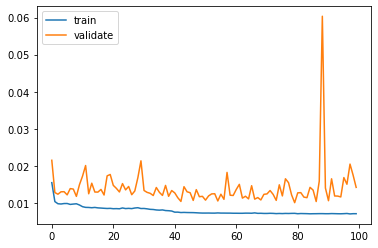

In [25]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()

In [26]:
test_rnn = RecurrentNeuralNet(lr=params["RNN_PARAMS"]['--learning-rate'],
                         T=params["RNN_PARAMS"]['--T'], 
                         alpha=params["RNN_PARAMS"]['--alpha'],
                         encoder_dim_1=params["RNN_PARAMS"]['--encoder-dim-1'],
                         encoder_dim_2=params["RNN_PARAMS"]['--encoder-dim-2'], 
                         decoder_dim_1=params["RNN_PARAMS"]['--decoder-dim-1'],
                         decoder_dim_2=params["RNN_PARAMS"]['--decoder-dim-2'])

In [30]:
rnn_model = test_rnn.get_model(length=len(data_df.columns), architecture='GRU')
rnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 660       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 24, 5)             0         
_________________________________________________________________
gru_1 (GRU)                  (None, 24, 5)             180       
_________________________________________________________________
time_distributed (TimeDistri (None, 24, 1)             6         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
Total params: 846
Trainable params: 846
Non-trainable params: 0
_________________________________________________________________


/home/steeve/Anaconda3/envs/hydroqc-env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [31]:
t0 = timeit.default_timer()

history = rnn_model.fit(
        train_inputs["X"],
        train_inputs["target"],
        batch_size=32,
        epochs=100,
        validation_data=(valid_inputs["X"], valid_inputs["target"]),
        shuffle=True,
        #callbacks=[earlystop, best_val, LogRunMetrics()],
        verbose=2,
    )

t1 = timeit.default_timer()
elapsed_time = t1 - t0
print(f'Training time: {elapsed_time} seconds')    

Epoch 1/100
521/521 - 7s - loss: 0.1044 - val_loss: 0.0988
Epoch 2/100
521/521 - 5s - loss: 0.0774 - val_loss: 0.0895
Epoch 3/100
521/521 - 5s - loss: 0.0680 - val_loss: 0.0873
Epoch 4/100
521/521 - 5s - loss: 0.0637 - val_loss: 0.0909
Epoch 5/100
521/521 - 5s - loss: 0.0614 - val_loss: 0.0874
Epoch 6/100
521/521 - 5s - loss: 0.0593 - val_loss: 0.0883
Epoch 7/100
521/521 - 5s - loss: 0.0580 - val_loss: 0.1157
Epoch 8/100
521/521 - 5s - loss: 0.0571 - val_loss: 0.0938
Epoch 9/100
521/521 - 5s - loss: 0.0563 - val_loss: 0.0855
Epoch 10/100
521/521 - 5s - loss: 0.0557 - val_loss: 0.0842
Epoch 11/100
521/521 - 5s - loss: 0.0554 - val_loss: 0.0889
Epoch 12/100
521/521 - 5s - loss: 0.0551 - val_loss: 0.0926
Epoch 13/100
521/521 - 5s - loss: 0.0547 - val_loss: 0.0947
Epoch 14/100
521/521 - 5s - loss: 0.0545 - val_loss: 0.0907
Epoch 15/100
521/521 - 5s - loss: 0.0542 - val_loss: 0.0864
Epoch 16/100
521/521 - 5s - loss: 0.0540 - val_loss: 0.0812
Epoch 17/100
521/521 - 5s - loss: 0.0537 - val_lo

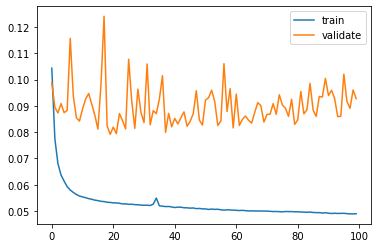

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validate')
plt.legend()
plt.show()